# 类比实验
- 32个受试者，按比例划分数据集，进行八折交叉验证
- 把测试受试者随机选择一个训练好的模型（不选择Wasserstein距离最近的模型）作为对比实验
- 与单受试者模型做对比，期望结果，准确率相差不多或比单受试者模型准确率略低
- 与所有受试者公用一个模型做对比，期望结果，比所有受试者公用模型准确率高很多

In [1]:
#加载飞桨、Numpy和相关类库
import numpy as np
import pyeeg as pe
import os
import random
import time

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot

from scipy.stats import wasserstein_distance

In [2]:
#加载一个受试者
def De_baseline(sub):
    dir='E:\JupyterNotebookWorkSpace\dataSet\\1280x258050(32x8064+2).npy'
    data=np.load(dir)
    subData = data[sub * 40 : (sub + 1) * 40]
    subData[: , -2:] = np.where(subData[: , -2:] >= 5 , 1 , -1)
    return subData

In [3]:
#数据集切60片，基线单独返回
def Data_set_partition(subData):
    features = subData[:,:-2]
    labels = subData[:,-2:]
    features = features.reshape(40,32,-1)
    baseline = features[:,:,:384]
    features = features[:,:,384:]
    
    dataList = []
    for i in range(40):
        for j in range(60):
            dataList.append(np.append(features[i][ : , j * 128 : (j + 1) * 128].reshape(-1) , labels[i]))

    dataList = np.array(dataList)

    return dataList, baseline

In [4]:
#特征提取
def feature_extraction(trainData, baseline):

    band = [4,8,13,16,30,45] #5 bands    band = [4,8,12,16,25,45]    
    window_size = 128 #Averaging band power of 1 sec
    step_size = 128 #Each 1 sec update once
    sample_rate = 128 #Sampling rate of 128 Hz

    features = trainData[:,:-2]
    labels = trainData[:,-2:]
    features = features.reshape(features.shape[0],32,128)

    newData=[]
    for i in range(features.shape[0]):    #样本数
        channel_features=[]
        for j in range(32):
            X = features[i][j]
            Y = pe.bin_power(X, band, sample_rate)
            channel_features += list(Y[0])
            ###################################################################################
        channel_features += list(labels[i])    #添加标签
        newData.append(channel_features)
    trainData = np.array(newData)

    #计算频域基线
    features = baseline

    newData=[]
    for i in range(features.shape[0]):    #电影数
        channel_features=[]
        for k in range(3):
            baseline_feature = []
            for j in range(32):
                X = features[i][j][k * 128 : (k + 1) * 128]
                Y = pe.bin_power(X, band, sample_rate)
                baseline_feature += list(Y[0])
            channel_features.append(baseline_feature)    #求基线的均值还是均值的基线？
        newData.append(np.array(channel_features).mean(axis = 0))
    newData = np.array(newData)
    
# 减去基线特征
    for i in range(40):
        trainData[i * 60 : (i + 1) * 60 , : 160] -= newData[i]

    return trainData

In [5]:
# AllSubFreq = []    #保存所有受试者的频域特征32*2400*160(不含标签)
# for sub in range(32):
#     SubData = De_baseline(sub)
#     dataList, baseline = Data_set_partition(SubData)
#     trainData = feature_extraction(dataList, baseline)
#     AllSubFreq.append(trainData)
# AllSubFreq = np.array(AllSubFreq)
# print(AllSubFreq.shape)
# AllSubFreq = np.reshape(AllSubFreq, (-1, 162))
# print(AllSubFreq.shape)
# np.save("./with_label_DE_baseline_AllSubFreq.npy",AllSubFreq)

In [6]:
# #计算KL散度
# import numpy as np
# import scipy.stats

# # 利用scipy API进行计算
# # scipy计算函数可以处理非归一化情况，因此这里使用
# # scipy.stats.entropy(x, y)或scipy.stats.entropy(px, py)均可
# KL = np.zeros((32,32))
# for i in range(32):
#     for j in range(32):
#         x = AllSubFreq[i]
#         y = AllSubFreq[j]
#         KL[i][j] = scipy.stats.entropy(x, y)
# print(KL)
# np.save("work/data/KL_AllSubFreq.npy",KL)

In [7]:
# #计算JS散度

# import numpy as np
# import scipy.stats

# def JS_divergence(p,q):
#     M=(p+q)/2
#     return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

# JS = np.zeros((32,32))
# for i in range(32):
#     for j in range(32):
#         x = AllSubFreq[i]
#         y = AllSubFreq[j]
#         JS[i][j] = JS_divergence(x, y)
# np.set_printoptions(threshold = 1e6)
# print(JS)
# np.save("work/data/JS_AllSubFreq.npy",JS)


In [8]:
# def Gaussian_normalization(trainData, testData):
#     """高斯归一化"""

#     #训练样本归一化
#     feature=trainData[:,:-2]
#     mean=feature.mean(axis=0)
#     std=feature.std(axis=0)
#     feature-=mean
#     feature/=std
#     trainData[:,:-2] = feature

#     #测试样本归一化
#     feature=testData[:,:-2]
#     feature-=mean
#     feature/=std
#     testData[:,:-2] = feature

#     return trainData, testData

In [9]:
#使用Wasserstein距离进行K-means聚类
from scipy.stats import wasserstein_distance

class K_Means(object):
    # k是分组数；tolerance‘中心点误差’；max_iter是迭代次数
    def __init__(self, k=2, tolerance=0.0000001, max_iter=30000):    #tolerance=0.0001,  max_iter=300
        self.k_ = k
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter

    def fit(self, data):
        self.centers_ = {}
        for i in range(self.k_):
            self.centers_[i] = data[i]

        for i in range(self.max_iter_):
            self.clf_ = {}
            for j in range(self.k_):
                self.clf_[j] = []
            # print("质点:",self.centers_)
            for SubIndexId, feature in enumerate(data):
                # distances = [np.linalg.norm(feature-self.centers[center]) for center in self.centers]
                distances = []
                for center in self.centers_:
                    # 欧拉距离
                    # np.sqrt(np.sum((features-self.centers_[center])**2))
                    distances.append(wasserstein_distance(feature, self.centers_[center]))#np.linalg.norm(feature - self.centers_[center])
                classification = distances.index(min(distances))
                self.clf_[classification].append(SubIndexId)

            # print("分组情况:",self.clf_)
            prev_centers = dict(self.centers_)
            
            self.flag = True    #聚类是否成功
            for c in self.clf_:
                if(len(self.clf_[c]) == 0):
                    self.flag = False
                    print('\n第{}次迭代：'.format(i))
                    print('************************聚类中心无样本截止！******************************')
                    return
                self.centers_[c] = np.average(data[np.array(self.clf_[c])], axis=0)

            # '中心点'是否在误差范围
            optimized = True
            for center in self.centers_:
                org_centers = prev_centers[center]
                cur_centers = self.centers_[center]
                if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
                    optimized = False
            if optimized:
                print('迭代次数：', i)
                break

    def predict(self, p_data):
        allIndex = []
        for oneTestSample in p_data:
            distances = [wasserstein_distance(oneTestSample, self.centers_[center]) for center in self.centers_]#np.linalg.norm(p_data - self.centers_[center])
            index = distances.index(min(distances))
            allIndex.append(index)
        return np.array(allIndex)

In [10]:
def W_K_means(n_cluster, trainSet):
    AllSubFreq = trainSet
    #print(AllSubFreq.shape)

    k_means = K_Means(k=n_cluster)
    k_means.fit(data  = AllSubFreq)
    return k_means
    # print(k_means.centers_)
    # for center in k_means.centers_:
    #     pyplot.scatter(k_means.centers_[center][0], k_means.centers_[center][1], marker='*', s=150)

    # for cat in k_means.clf_:
    #     for point in k_means.clf_[cat]:
    #         pyplot.scatter(point[0], point[1], c=('r' if cat == 0 else 'b'))

    # predict = [[2, 1],[6, 9]]
    # for feature in predict:
    #     cat = k_means.predict(feature)
    #     pyplot.scatter(feature[0], feature[1], c=('r' if cat == 0 else 'b'), marker='x')

    # pyplot.show()

In [11]:
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def trainModel(trainData, testData, Edim, modelId):
    dim = Edim
    
    trainLabel = trainData[:, -2:]
    trainData = trainData[:, :-2]
    trainLabel = trainLabel[:, dim]
    
    testLabel = testData[:, -2:]
    testData = testData[:, :-2]
    testLabel = testLabel[:, dim]
    print('model {}\ttrainNum:{}\ttestNum:{}\t训练：测试 = {:.2f}'.format(modelId, trainData.shape[0], testData.shape[0], trainData.shape[0] / testData.shape[0]), end = '\t')
    
    svmModel = svm.SVC()
    svmModel.fit(trainData, trainLabel) 
    ypredict=svmModel.predict(testData)
    acc = accuracy_score(ypredict,testLabel)
    print("SVMacc = {:.2f}".format(acc)) 

#     rfModel = RandomForestClassifier(n_estimators=512, n_jobs=16)
#     rfModel.fit(trainData, trainLabel)
#     ypredict = rfModel.predict(testData)
#     acc = accuracy_score(ypredict,testLabel)
#     print("acc = {:.2f}".format(acc))
    
    return acc, testData.shape[0]

数据集shape： (76800, 162)
-------------------------------------------第1折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 1
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.49
K=2：	迭代次数： 2
model 0	trainNum:63468	testNum:8722	训练：测试 = 7.28	SVMacc = 0.48
model 1	trainNum:3732	testNum:878	训练：测试 = 4.25	SVMacc = 0.41
K=3：	迭代次数： 24
model 0	trainNum:37806	testNum:4692	训练：测试 = 8.06	SVMacc = 0.50
model 1	trainNum:2264	testNum:270	训练：测试 = 8.39	SVMacc = 0.57
model 2	trainNum:27130	testNum:4638	训练：测试 = 5.85	SVMacc = 0.45
K=4：	迭代次数： 47
model 0	trainNum:46993	testNum:4797	训练：测试 = 9.80	SVMacc = 0.51
model 1	trainNum:2148	testNum:205	训练：测试 = 10.48	SVMacc = 0.54
model 2	trainNum:15400	testNum:3898	训练：测试 = 3.95	SVMacc = 0.42
model 3	trainNum:2659	testNum:700	训练：测试 = 3.80	SVMacc = 0.40
K=5：	迭代次数： 53
model 0	trainNum:31854	testNum:3853	训练：测试 = 8.27	SVMacc = 0.52
model 1	trainNum:1829	testNum:58	训练：测试 = 31.53	SVMacc = 0.12
m

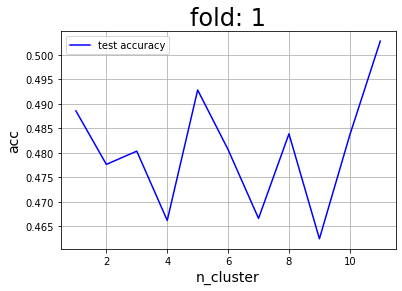

-------------------------------------------第2折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.61
K=2：	迭代次数： 10
model 0	trainNum:63226	testNum:9600	训练：测试 = 6.59	SVMacc = 0.59
model1无测试样本
K=3：	迭代次数： 39
model 0	trainNum:7814	testNum:538	训练：测试 = 14.52	SVMacc = 0.55
model 1	trainNum:56115	testNum:9062	训练：测试 = 6.19	SVMacc = 0.59
model2无测试样本
K=4：	迭代次数： 41
model 0	trainNum:3142	testNum:82	训练：测试 = 38.32	SVMacc = 0.30
model 1	trainNum:48397	testNum:8909	训练：测试 = 5.43	SVMacc = 0.58
model2无测试样本
model 3	trainNum:13406	testNum:609	训练：测试 = 22.01	SVMacc = 0.54
K=5：	迭代次数： 79
model 0	trainNum:2621	testNum:60	训练：测试 = 43.68	SVMacc = 0.32
model 1	trainNum:25899	testNum:2971	训练：测试 = 8.72	SVMacc = 0.59
model2无测试样本
model3无测试样本
model 4	trainNum:32817	testNum:6569	训练：测试 = 5.00	SVMacc = 0.58
K=6：	迭代次数： 57
model 0	trainNum:1396	testNum:21	训练：测试 = 66.48	SVMacc = 0.24
model 1	tr

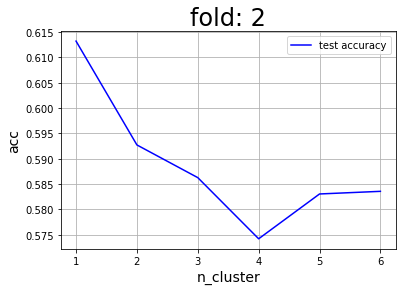

-------------------------------------------第3折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.53
K=2：	迭代次数： 5
model 0	trainNum:60734	testNum:9230	训练：测试 = 6.58	SVMacc = 0.56
model 1	trainNum:6466	testNum:370	训练：测试 = 17.48	SVMacc = 0.19
K=3：	迭代次数： 57
model 0	trainNum:47620	testNum:5961	训练：测试 = 7.99	SVMacc = 0.56
model 1	trainNum:17281	testNum:3536	训练：测试 = 4.89	SVMacc = 0.50
model 2	trainNum:2299	testNum:103	训练：测试 = 22.32	SVMacc = 0.53
K=4：	迭代次数： 38
model 0	trainNum:3386	testNum:1446	训练：测试 = 2.34	SVMacc = 0.57
model 1	trainNum:52227	testNum:6116	训练：测试 = 8.54	SVMacc = 0.53
model 2	trainNum:2075	testNum:65	训练：测试 = 31.92	SVMacc = 0.00
model 3	trainNum:9512	testNum:1973	训练：测试 = 4.82	SVMacc = 0.45
K=5：	迭代次数： 56
model 0	trainNum:2489	testNum:1197	训练：测试 = 2.08	SVMacc = 0.57
model 1	trainNum:23595	testNum:4528	训练：测试 = 5.21	SVMacc = 0.54
model 2	trainNum:1722	

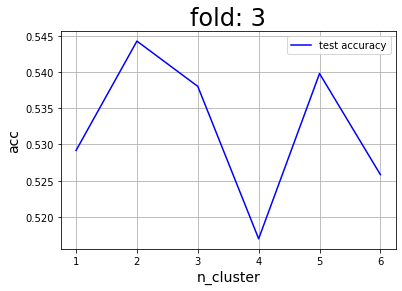

-------------------------------------------第4折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.46
K=2：	迭代次数： 10
model 0	trainNum:63308	testNum:9580	训练：测试 = 6.61	SVMacc = 0.49
model 1	trainNum:3892	testNum:20	训练：测试 = 194.60	SVMacc = 1.00
K=3：	迭代次数： 22
model 0	trainNum:5944	testNum:669	训练：测试 = 8.88	SVMacc = 0.59
model 1	trainNum:57919	testNum:8931	训练：测试 = 6.49	SVMacc = 0.47
model2无测试样本
K=4：	迭代次数： 42
model 0	trainNum:2985	testNum:238	训练：测试 = 12.54	SVMacc = 0.50
model 1	trainNum:49501	testNum:8215	训练：测试 = 6.03	SVMacc = 0.51
model2无测试样本
model 3	trainNum:12473	testNum:1147	训练：测试 = 10.87	SVMacc = 0.44
K=5：	迭代次数： 80
model 0	trainNum:2521	testNum:191	训练：测试 = 13.20	SVMacc = 0.45
model 1	trainNum:24909	testNum:3552	训练：测试 = 7.01	SVMacc = 0.44
model2无测试样本
model 3	trainNum:3766	testNum:140	训练：测试 = 26.90	SVMacc = 0.79
model 4	trainNum:34209	testNum:5717	训练：测试 = 5.

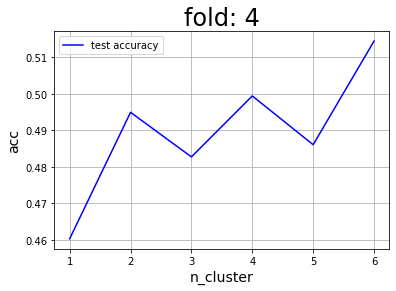

-------------------------------------------第5折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.56
K=2：	迭代次数： 7
model 0	trainNum:62216	testNum:9555	训练：测试 = 6.51	SVMacc = 0.56
model 1	trainNum:4984	testNum:45	训练：测试 = 110.76	SVMacc = 0.80
K=3：	迭代次数： 22
model 0	trainNum:5089	testNum:421	训练：测试 = 12.09	SVMacc = 0.61
model 1	trainNum:58757	testNum:9177	训练：测试 = 6.40	SVMacc = 0.55
model 2	trainNum:3354	testNum:2	训练：测试 = 1677.00	SVMacc = 0.00
K=4：	迭代次数： 33
model 0	trainNum:3014	testNum:93	训练：测试 = 32.41	SVMacc = 0.61
model 1	trainNum:48772	testNum:8478	训练：测试 = 5.75	SVMacc = 0.55
model2无测试样本
model 3	trainNum:13158	testNum:1029	训练：测试 = 12.79	SVMacc = 0.43
K=5：	迭代次数： 76
model 0	trainNum:2663	testNum:51	训练：测试 = 52.22	SVMacc = 0.63
model 1	trainNum:25126	testNum:3994	训练：测试 = 6.29	SVMacc = 0.53
model2无测试样本
model 3	trainNum:4043	testNum:76	训练：测试 = 53.20	SVMacc = 0.55

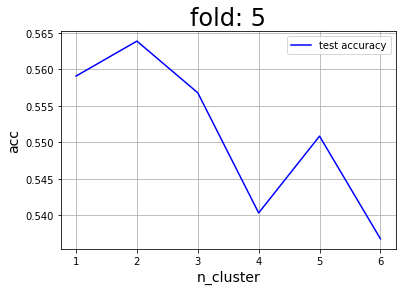

-------------------------------------------第6折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.54
K=2：	迭代次数： 51
model 0	trainNum:49334	testNum:5035	训练：测试 = 9.80	SVMacc = 0.55
model 1	trainNum:17866	testNum:4565	训练：测试 = 3.91	SVMacc = 0.53
K=3：	迭代次数： 58
model 0	trainNum:3515	testNum:625	训练：测试 = 5.62	SVMacc = 0.51
model 1	trainNum:57704	testNum:5365	训练：测试 = 10.76	SVMacc = 0.53
model 2	trainNum:5981	testNum:3610	训练：测试 = 1.66	SVMacc = 0.49
K=4：	迭代次数： 27
model 0	trainNum:2177	testNum:504	训练：测试 = 4.32	SVMacc = 0.46
model 1	trainNum:34915	testNum:3689	训练：测试 = 9.46	SVMacc = 0.54
model 2	trainNum:2574	testNum:2776	训练：测试 = 0.93	SVMacc = 0.50
model 3	trainNum:27534	testNum:2631	训练：测试 = 10.47	SVMacc = 0.47
K=5：	迭代次数： 54
model 0	trainNum:8443	testNum:526	训练：测试 = 16.05	SVMacc = 0.54
model 1	trainNum:34293	testNum:3883	训练：测试 = 8.83	SVMacc = 0.54
model 2	trainNum:23

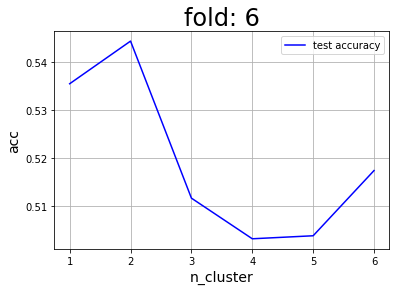

-------------------------------------------第7折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.61
K=2：	迭代次数： 5
model 0	trainNum:59006	testNum:8801	训练：测试 = 6.70	SVMacc = 0.60
model 1	trainNum:8194	testNum:799	训练：测试 = 10.26	SVMacc = 0.56
K=3：	迭代次数： 35
model 0	trainNum:4459	testNum:851	训练：测试 = 5.24	SVMacc = 0.61
model 1	trainNum:59807	testNum:8505	训练：测试 = 7.03	SVMacc = 0.60
model 2	trainNum:2934	testNum:244	训练：测试 = 12.02	SVMacc = 0.67
K=4：	迭代次数： 41
model 0	trainNum:2488	testNum:395	训练：测试 = 6.30	SVMacc = 0.58
model 1	trainNum:49734	testNum:6808	训练：测试 = 7.31	SVMacc = 0.61
model 2	trainNum:2105	testNum:117	训练：测试 = 17.99	SVMacc = 0.63
model 3	trainNum:12873	testNum:2280	训练：测试 = 5.65	SVMacc = 0.49
K=5：	迭代次数： 82
model 0	trainNum:2188	testNum:311	训练：测试 = 7.04	SVMacc = 0.54
model 1	trainNum:26329	testNum:3606	训练：测试 = 7.30	SVMacc = 0.57
model 2	trainNum:1761	te

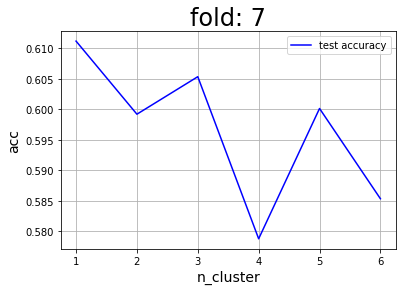

-------------------------------------------第8折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	SVMacc = 0.60
K=2：	迭代次数： 7
model 0	trainNum:62087	testNum:9600	训练：测试 = 6.47	SVMacc = 0.57
model1无测试样本
K=3：	迭代次数： 23
model 0	trainNum:6011	testNum:258	训练：测试 = 23.30	SVMacc = 0.55
model 1	trainNum:57832	testNum:9342	训练：测试 = 6.19	SVMacc = 0.57
model2无测试样本
K=4：	迭代次数： 51
model 0	trainNum:3111	testNum:39	训练：测试 = 79.77	SVMacc = 0.67
model 1	trainNum:48247	testNum:8581	训练：测试 = 5.62	SVMacc = 0.55
model2无测试样本
model 3	trainNum:13581	testNum:980	训练：测试 = 13.86	SVMacc = 0.55
K=5：	迭代次数： 74
model 0	trainNum:2662	testNum:23	训练：测试 = 115.74	SVMacc = 0.70
model 1	trainNum:24540	testNum:4514	训练：测试 = 5.44	SVMacc = 0.57
model2无测试样本
model 3	trainNum:4021	testNum:15	训练：测试 = 268.07	SVMacc = 0.80
model 4	trainNum:34161	testNum:5048	训练：测试 = 6.77	SVMacc = 0.54
K=6：	迭代次数： 48
model 0	trainNum:7687

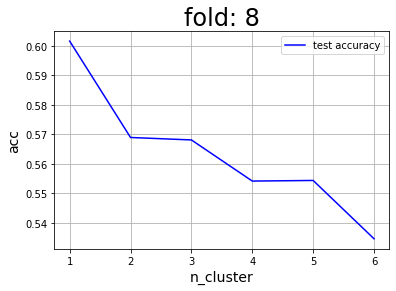

d:\python37\lib\site-packages\ipykernel_launcher.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [12]:
# 开始对训练集聚类
valence_or_arousal = -2    #-2 : valence;-1 : arousal

allSub = np.load("./with_label_DE_baseline_AllSubFreq.npy")
print('数据集shape：', allSub.shape)

subIndex = np.array([i for i in range(32 * 2400)])
# 8折交叉验证
allAcc = []
for fold in range(1, 9):
    print('-------------------------------------------第{}折交叉验证开始-------------------------------------------------'.format(fold))
    # 数据集划分
    testIndex = subIndex[(fold - 1) * 4 * 2400 : fold * 4 * 2400]
    trainIndex = subIndex[np.array(list(set(subIndex) - set(subIndex[(fold - 1) * 4 * 2400 : fold * 4 * 2400])))]

    trainSet = allSub[trainIndex]
    testSet = allSub[testIndex]
    print('trainSet.shape = {}, testSet.shape = {}'.format(trainSet.shape, testSet.shape))

    trainFeature = trainSet[:, :-2]
    testFeature = testSet[:, :-2]

    foldAcc = []
    for num_cluster in range(1, 33):
        print('K={}：'.format(num_cluster),end = '\t')
        #    *** 在这里我们关心哪些人的哪些视频被聚在了一起 ***    #
        k_means_machine = W_K_means(num_cluster, trainFeature)
        if(k_means_machine.flag == False):
            continue
        # 使用建立的K-means模型对测试集分类
        allIndex = k_means_machine.predict(testFeature)

        classList = k_means_machine.clf_
        clusterMean = []
        K_ModelAcc = []
        for j in range(len(classList)):
            testData = testSet[allIndex == j]
            if(testData.shape[0]==0):
                print('model{}无测试样本'.format(j))
                continue
            acc, testNum = trainModel(trainSet[np.array(classList[j])], testData, valence_or_arousal, modelId = j)
            K_ModelAcc.append(acc)
            # 求加权准确率
            clusterMean.append(acc * testNum)
        clusterMean = np.array(clusterMean).sum() / testSet.shape[0]
        foldAcc.append(clusterMean)
        allAcc.append(K_ModelAcc)
        
    plt.title("fold: {}".format(fold), fontsize=24)
    plt.xlabel("n_cluster", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    n_cluster = [i for i in range(1, len(foldAcc) + 1)]
    plt.plot(n_cluster, foldAcc, color='blue', label='test accuracy')

    plt.grid()
    plt.legend()
    plt.show()
np.save('所有准确率_8折x32种聚类SVM_聚类容忍度调小1000倍.npy', np.array(allAcc))

In [13]:
#    *** 在这里我们关心哪些人的哪些视频被聚在了一起 ***    #
# 除零警告
# 为什么聚一类，一次都没迭代就收敛了，至少迭代一次吧，tolerance，是不是容忍度太高了
# 聚类中心初始化问题，可能会在迭代过程中出现某个聚类中心中没有样本的情况